In [1]:
#import datas.mnist_data as mnist_local
from data import input_data
mnist = input_data.read_data_sets("./data/", one_hot=True)

D:\ProgramData\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [2]:
# import modules
# ignore future waring
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#from scipy.stats import norm

In [3]:
# 트레이닝 파라메터
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 1000

In [4]:
# 네트워크 파라메터
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 10 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

In [5]:
# 변수 초기화 (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [6]:
# X(이미지)의 입력값(No labels, only pictures)
X = tf.placeholder(np.float32, [None, num_input]) # 무한대 x 784 행렬

In [13]:
# 모델의 wright와 bias의 배열값
# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([num_input, num_hidden_1])),
    'z_mean': tf.Variable(glorot_init([num_hidden_1, num_hidden_2])),
    'z_std': tf.Variable(glorot_init([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(glorot_init([num_hidden_2, num_hidden_1])),
    'decoder_out': tf.Variable(glorot_init([num_hidden_1, num_input]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([num_hidden_1])),
    'z_mean': tf.Variable(glorot_init([num_hidden_2])),
    'z_std': tf.Variable(glorot_init([num_hidden_2])),
    'decoder_b1': tf.Variable(glorot_init([num_hidden_1])),
    'decoder_out': tf.Variable(glorot_init([num_input]))
}

In [14]:
# Building the encoder
#input_image = tf.placeholder(tf.float32, shape=[None, num_input])
encoder = tf.matmul(X, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [15]:
# 인코더 설정
def encode_func(x):
    en1 = tf.matmul(X, weights['encoder_h1']) + biases['encoder_b1']
    en2 = tf.nn.tanh(en1)
    z_m = tf.matmul(en2, weights['z_mean']) + biases['z_mean']
    z_s = tf.matmul(en2, weights['z_std']) + biases['z_std']
    eps = tf.random_normal(tf.shape(z_s), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
    z = z_m
    return z

In [16]:
# 디코더 설정
def decode_func(z) :
    de1 = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
    de1 = tf.nn.tanh(de1)
    de2 = tf.matmul(de1, weights['decoder_out']) + biases['decoder_out']
    recon = tf.nn.sigmoid(de2)
    return recon

In [17]:
# VAE Loss function 정의
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

In [18]:
# 모델 생성
encode_op = encode_func(X)
decode_op = decode_func(encode_op)

In [19]:
# Loss Function 및 optimizer 설정
loss_op = vae_loss(decode_op, X)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

In [20]:
# 전체 변수 초기화 선언
init = tf.global_variables_initializer()

In [21]:
# TF session 시작
sess = tf.Session()

# initializer 실행
sess.run(init)

# 학습 시작
# 학습횟수(epoch = num_steps = 30000)
for epoch in range(1, num_steps+1):    
    # batch_size 만큼 다음 mini batch를 가져옴
    X_images, _ = mnist.train.next_batch(batch_size)
    
    # 로그
    _, l = sess.run([train_op, loss_op], feed_dict={X: X_images})
    
    # Display logs per step
    if epoch % display_step == 0 or epoch == 1:
        print('epoch %i: Minibatch Loss: %f' % (epoch, l))

print("학습완료! (loss : " + str(l) + ")")

 

epoch 1: Minibatch Loss: 620.466614
epoch 1000: Minibatch Loss: 132.576889
epoch 2000: Minibatch Loss: 130.529526
epoch 3000: Minibatch Loss: 120.025238
epoch 4000: Minibatch Loss: 118.050507
epoch 5000: Minibatch Loss: 116.605026
epoch 6000: Minibatch Loss: 120.517166
epoch 7000: Minibatch Loss: 114.021881
epoch 8000: Minibatch Loss: 109.037865
epoch 9000: Minibatch Loss: 111.040649
epoch 10000: Minibatch Loss: 112.129433
epoch 11000: Minibatch Loss: 116.961777
epoch 12000: Minibatch Loss: 117.322044
epoch 13000: Minibatch Loss: 105.691544
epoch 14000: Minibatch Loss: 114.540329
epoch 15000: Minibatch Loss: 109.827698
epoch 16000: Minibatch Loss: 108.352356
epoch 17000: Minibatch Loss: 118.670212
epoch 18000: Minibatch Loss: 113.581429
epoch 19000: Minibatch Loss: 104.873474
epoch 20000: Minibatch Loss: 107.950623
epoch 21000: Minibatch Loss: 110.337662
epoch 22000: Minibatch Loss: 110.626442
epoch 23000: Minibatch Loss: 102.929459
epoch 24000: Minibatch Loss: 110.884239
epoch 25000: 

Original Images


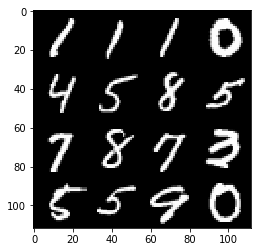

Reconstructed Images


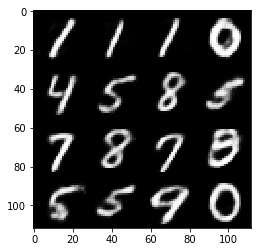

In [22]:
# 테스트 시작

# Generator takes noise as input
noise_input = tf.placeholder(tf.float32, shape=[None, num_hidden_2])
# Rebuild the decoder to create image from noise
decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))

for i in range(n):
    # MNIST test set
    test_X, _ = mnist.train.next_batch(batch_size)
    
    g = sess.run(decode_op, feed_dict={X: test_X})

    # 원본 이미지를 가져와서 출력
    for j in range(n):
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = test_X[j].reshape([28, 28])
    # 재생성된 이미지를 가져와서 출력
    for j in range(n):
        # Draw the generated digits
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

# 테스트 결과 출력
print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()